# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='~/../images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='~/../images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [30]:
# def melt_data(df): # BAD PROVIDED FUNCTION
#     melted = pd.melt(df, id_vars=['RegionName', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
#     melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
#     melted = melted.dropna(subset=['value'])
#     return melted.groupby('time').aggregate({'value':'mean'})

# melt_df = melt_data(df)

In [31]:
# !pip install -U fsds_100719
from fsds_100719.imports import *
from plotly import express as px
import plotly.graph_objects as go

## Workflow Thoughts

1. Start analysis in a state-by-state fashion. 
    - Groupby state and get groups
2. Model each state independently
    - start with NY
    
    - Start with zipcode 12211 (home in ny)

3. Train Test Split DF
    - Time Block Class for Model Validation? 
    - Split train/test by integer index based on `len(data)//test_size`
    
4. Perform seasonal decompositon
    - Try both decomposed residuals as well as raw time series (change `stationarity=True` if running resid

5. Check for stationarity

6. pmdarima
    



In [32]:
pd.set_option('display.max_columns',0)
df=pd.read_csv('zillow_data.csv')
display(df.head().style.set_caption('Original DataFrame'))

## Fixed Melt Function for Project df

def melt_data(df): #formerly called it melt_data_student with REED
    melted = pd.melt(df, id_vars=['RegionID','RegionName', 'City', 'State', 'Metro', 'CountyName', 
                                  'SizeRank'], var_name='Month', value_name='MeanValue')
    melted['Month'] = pd.to_datetime(melted['Month'], format='%Y-%m')
    melted = melted.dropna(subset=['MeanValue'])
    return melted

df = melt_data(df)
display(df.head().style.set_caption('Melted DataFrame'))


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200,335400,336500,337600,338500,339500,340400,341300,342600,344400,345700,346700,347800,349000,350400,352000,353900,356200,358800,361800,365700,370200,374700,378900,383500,388300,393300,398500,403800,409100,414600,420100,426200,432600,438600,444200,450000,455900,462100,468500,475300,482500,490200,498200,507200,516800,526300,535300,544500,553500,562400,571200,579800,588100,596300,604200,612200,620200,627700,634500,641000,647000,652700,658100,663300,668400,673400,678300,683200,688300,693300,698000,702400,706400,710200,714000,717800,721700,725700,729900,733400,735600,737200,739000,740900,742700,744400,746000,747200,748000,749000,750200,752300,755300,759200,764000,769600,775600,781900,787900,793200,798200,803100,807900,812900,818100,823100,828300,834100,839800,845600,851800,858000,864400,870700,876200,880700,884400,887600,890500,893300,895500,897300,899000,900400,902000,904400,907100,909700,911900,913000,913000,912000,909300,905300,901400,897900,895400,893600,891100,887000,881700,875900,870300,865100,859000,851500,843800,836400,830700,827300,824800,821600,818300,814600,809800,803600,795500,786900,780700,776900,774700,774200,774400,774600,775600,777800,775200,767900,764700,766100,764100,759700,754900,746200,737300,730800,729300,730200,730700,730000,730100,730100,731200,733900,735500,735400,734400,737500,737700,733700,734000,740300,744600,750500,760400,771800,780600,787900,794100,798900,802300,806100,810900,817400,826800,837900,848100,853800,856700,856600,854400,853000,856200,859700,863900,872900,883300,889500,892800,893600,891300,889900,891500,893000,893000,895000,901200,909400,915000,916700,917700,919800,925800,937100,948200,951000,952500,958600,966200,970400,973900,974700,972600,974300,980800,988000,994700,998700,997000,993700,991300,989200,991300,9991

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Month,MeanValue
0,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04-01 00:00:00,334200
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04-01 00:00:00,235700
2,91982,77494,Katy,TX,Houston,Harris,3,1996-04-01 00:00:00,210400
3,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04-01 00:00:00,498100
4,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01 00:00:00,77300


In [33]:
def make_dateindex(df_to_add_index, index_col='Month',index_name = 'date',
                   drop=True,freq=None,verbose=True):
    
    df = df_to_add_index.copy()
    df.reset_index(drop=True)
    
    ## Make datetime column (to make into index)
    df[index_name] = pd.to_datetime(df[index_col], errors='coerce')
    
#     if index_name != df.index.name:
    df = df.set_index(index_name,drop=drop)
    
#     if freq is not None:
#         try:
#             df = df.resample(freq,fill_method='ffill').mean()
#         except Exception as e:
#             print(f"Error: {e}, index.name={df.index.name}")
        
    if verbose:
        display(df.index)
        
    return df

In [34]:
df = make_dateindex(df,)
df.head()

DatetimeIndex(['1996-04-01', '1996-04-01', '1996-04-01', '1996-04-01',
               '1996-04-01', '1996-04-01', '1996-04-01', '1996-04-01',
               '1996-04-01', '1996-04-01',
               ...
               '2018-04-01', '2018-04-01', '2018-04-01', '2018-04-01',
               '2018-04-01', '2018-04-01', '2018-04-01', '2018-04-01',
               '2018-04-01', '2018-04-01'],
              dtype='datetime64[ns]', name='date', length=3744704, freq=None)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Month,MeanValue
date,,,,,,,,,
1996-04-01,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04-01,334200.0
1996-04-01,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04-01,235700.0
1996-04-01,91982,77494,Katy,TX,Houston,Harris,3,1996-04-01,210400.0
1996-04-01,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04-01,498100.0
1996-04-01,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01,77300.0


### NY

In [35]:
ny= df.loc[df['State']=='NY']
ny

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Month,MeanValue
date,,,,,,,,,
1996-04-01,61807,10467,New York,NY,New York,Bronx,7,1996-04-01,152900.0
1996-04-01,62037,11226,New York,NY,New York,Kings,11,1996-04-01,162000.0
1996-04-01,62087,11375,New York,NY,New York,Queens,13,1996-04-01,252400.0
1996-04-01,62045,11235,New York,NY,New York,Kings,14,1996-04-01,190500.0
1996-04-01,61703,10128,New York,NY,New York,New York,22,1996-04-01,3676700.0
...,...,...,...,...,...,...,...,...,...
2018-04-01,62430,12153,Sand Lake,NY,Albany,Rensselaer,14664,2018-04-01,207300.0
2018-04-01,62433,12156,Schodack,NY,Albany,Rensselaer,14694,2018-04-01,199400.0
2018-04-01,62599,12480,Shandaken,NY,Kingston,Ulster,14703,2018-04-01,163700.0


In [36]:
ny_mean = ny.groupby('RegionName').resample('MS').mean()
display(ny_mean.head())

ts = ny_mean.loc[(12211), 'MeanValue']

RegionID  RegionName  SizeRank  MeanValue
RegionName date                                                 
10011      2005-01-01     61625       10011        21  3762100.0
           2005-02-01     61625       10011        21  3908800.0
           2005-03-01     61625       10011        21  4023200.0
           2005-04-01     61625       10011        21  4084800.0
           2005-05-01     61625       10011        21  4080800.0

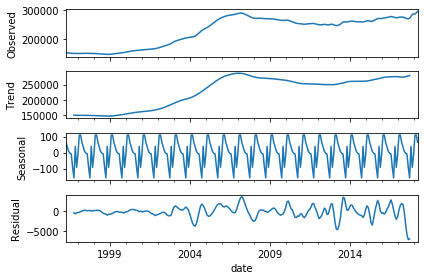

In [37]:
from statsmodels.tsa.seasonal import seasonal_decompose
ts = ts.asfreq('MS')
model = seasonal_decompose(ts)
model.plot();

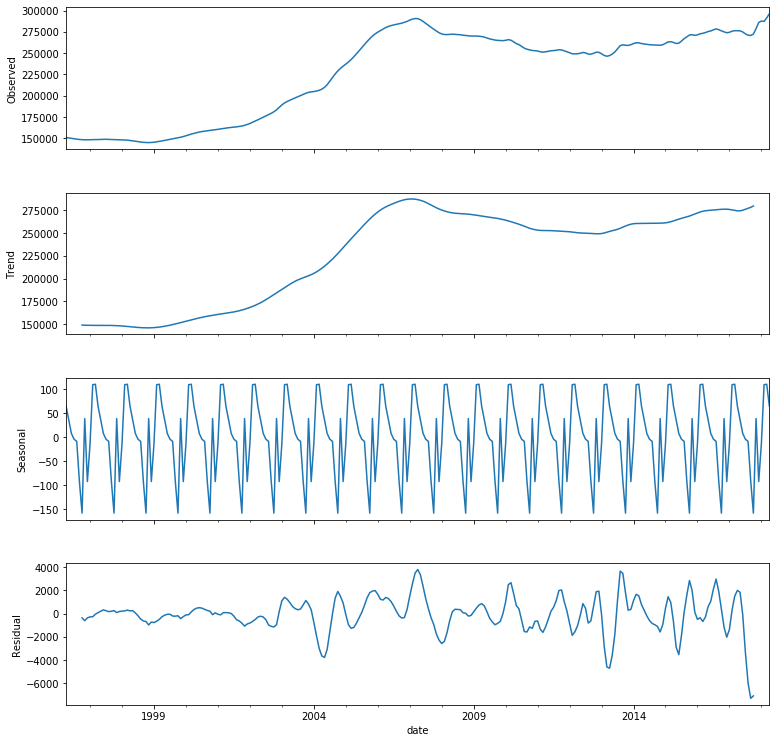

In [38]:
def seasonal_decomp_plot(ts,decomp_kws={},figwidth=12,figheight=12):
#     import statsmodels.api as sm
    from statsmodels.tsa.seasonal import seasonal_decompose
    decomp = seasonal_decompose(ts, **decomp_kws)
    # fig,ax = plt.subplots(figsize=(12,12))
    fig = decomp.plot()
    ax = fig.get_axes()
    fig = ax[0].get_figure()
    
    fig.set_figheight(figheight)
    fig.set_figwidth(figwidth)
    
    return decomp


    
decomp=seasonal_decomp_plot(ts)
# px.line(ts)
# decomp.nobs

In [39]:
df_res = df.groupby([pd.Grouper(freq='MS'),'RegionName']).mean()
df_res

RegionID  SizeRank  MeanValue
date       RegionName                               
1996-04-01 1001           58196      5851   113100.0
           1002           58197      4200   161000.0
           1005           58200     11214   103100.0
           1007           58201      6851   133400.0
           1008           58202     14548   117500.0
...                         ...       ...        ...
2018-04-01 99709         100384      4527   262400.0
           99712         100387      8439   274600.0
           99801         100459      4107   413300.0
           99835         100473      8659   404800.0
           99901         100478      7294   305100.0

[3744704 rows x 3 columns]

In [40]:
# df = df.resample('MS')
# df

### NY

In [41]:
mpl.rcParams['figure.figsize']=12,6

In [43]:
# states = df.groupby('State').groups

# for state,idx in states.items():
#     states[state] = df.loc[idx]

ny = df.groupby('State').get_group('NY')
ny.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Month,MeanValue
date,,,,,,,,,
1996-04-01,61807,10467,New York,NY,New York,Bronx,7,1996-04-01,152900.0
1996-04-01,62037,11226,New York,NY,New York,Kings,11,1996-04-01,162000.0
1996-04-01,62087,11375,New York,NY,New York,Queens,13,1996-04-01,252400.0
1996-04-01,62045,11235,New York,NY,New York,Kings,14,1996-04-01,190500.0
1996-04-01,61703,10128,New York,NY,New York,New York,22,1996-04-01,3676700.0


In [44]:
# home = ny.groupby('RegionName').get_group(12211)
# home['MeanValue'].plot()

In [45]:
ny_mean = ny.groupby('RegionName').resample('MS').mean()
display(ny_mean.head())

RegionID  RegionName  SizeRank  MeanValue
RegionName date                                                 
10011      2005-01-01     61625       10011        21  3762100.0
           2005-02-01     61625       10011        21  3908800.0
           2005-03-01     61625       10011        21  4023200.0
           2005-04-01     61625       10011        21  4084800.0
           2005-05-01     61625       10011        21  4080800.0

In [46]:
ny_mean.index

MultiIndex([(10011, '2005-01-01'),
            (10011, '2005-02-01'),
            (10011, '2005-03-01'),
            (10011, '2005-04-01'),
            (10011, '2005-05-01'),
            (10011, '2005-06-01'),
            (10011, '2005-07-01'),
            (10011, '2005-08-01'),
            (10011, '2005-09-01'),
            (10011, '2005-10-01'),
            ...
            (14905, '2017-07-01'),
            (14905, '2017-08-01'),
            (14905, '2017-09-01'),
            (14905, '2017-10-01'),
            (14905, '2017-11-01'),
            (14905, '2017-12-01'),
            (14905, '2018-01-01'),
            (14905, '2018-02-01'),
            (14905, '2018-03-01'),
            (14905, '2018-04-01')],
           names=['RegionName', 'date'], length=265015)

In [47]:
# df_orig['RegionName'].loc['90275']

date
1996-04-01    150900.0
1996-05-01    150400.0
1996-06-01    149900.0
1996-07-01    149400.0
1996-08-01    149000.0
                ...   
2017-12-01    286000.0
2018-01-01    287700.0
2018-02-01    287300.0
2018-03-01    291400.0
2018-04-01    296300.0
Name: MeanValue, Length: 265, dtype: float64

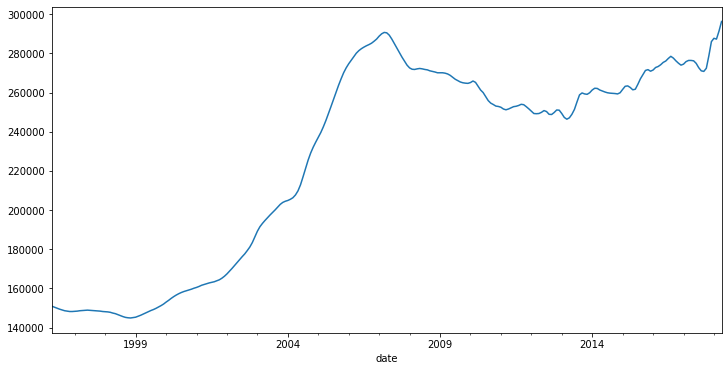

In [48]:
ts = ny_mean.loc[12211,'MeanValue']
ts.plot()
ts

### Selecting Smaller Time Window

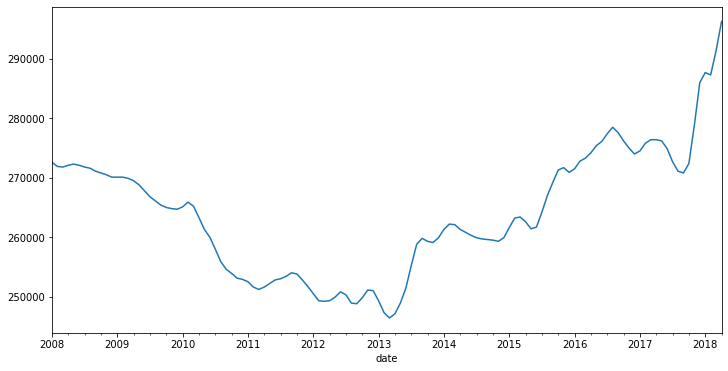

In [49]:
start_date = '2008'
ts = ts.loc[start_date:]
ts.plot()

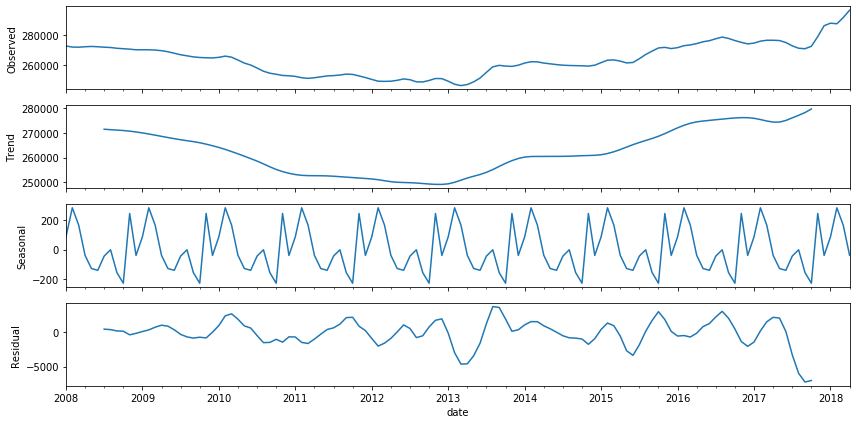

In [50]:
from statsmodels.tsa.seasonal import seasonal_decompose
ts = ts.asfreq('MS')
model = seasonal_decompose(ts)
model.plot();

## stationarity check

In [51]:
## Lab Function
def stationarity_check(TS,plot=True,col=None,rollwindow=8):
    """
    Performs the Augmented Dickey-Fuller unit root test on a time series.

    - The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, with the alternative that there is no unit root. 
        - A unit root (also called a unit root process or a difference stationary process) 
        is a stochastic trend in a time series, sometimes called a “random walk with drift”; 
        - If a time series has a unit root, it shows a systematic pattern that is unpredictable, and non-stationary.
        
    From: https://learn.co/tracks/data-science-career-v2/module-4-a-complete-data-science-project-using-multiple-regression/working-with-time-series-data/time-series-decomposition
    """
    # Import adfuller
    from statsmodels.tsa.stattools import adfuller

    if col is not None:
        # Perform the Dickey Fuller Test
        dftest = adfuller(TS[col]) # change the passengers column as required 
    else:
        dftest=adfuller(TS)
 
    if plot:
        # Calculate rolling statistics
        rolmean = TS.rolling(window = rollwindow, center = False).mean()
        rolstd = TS.rolling(window = rollwindow, center = False).std()

        #Plot rolling statistics:
        fig = plt.figure(figsize=(12,6))
        orig = plt.plot(TS, color='blue',label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean')
        std = plt.plot(rolstd, color='black', label = 'Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')
#     plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print ('[i] Results of Dickey-Fuller Test:')

    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','# of Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        

    sig = dfoutput['p-value']<.05
    print (dfoutput)
    print()
    if sig:
        print(f"[i] p-val {dfoutput['p-value'].round(4)} is <.05, so we reject the null hypothesis.")
        print("\tThe time series is NOT stationary.")
    else:
        print(f"[i] p-val {dfoutput['p-value'].round(4)} is >.05, therefore we support the null hypothesis.")
        print('\tThe time series IS stationary.')
    
    return dfoutput

### EDA/Stationarity

[i] Results of Dickey-Fuller Test:
Test Statistic                   0.310205
p-value                          0.977808
# of Lags Used                   9.000000
Number of Observations Used    114.000000
Critical Value (1%)             -3.489058
Critical Value (5%)             -2.887246
Critical Value (10%)            -2.580481
dtype: float64

[i] p-val 0.9778 is >.05, therefore we support the null hypothesis.
	The time series IS stationary.


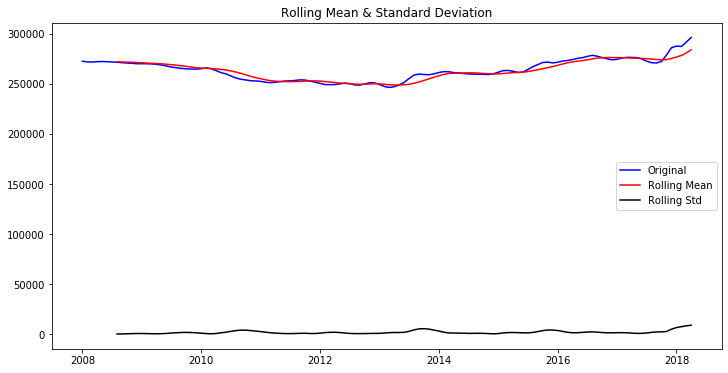

In [52]:
stationarity_check(ts);

In [77]:
window=3
mean = ts.rolling(window).mean()
std = ts.rolling(window).std()
mean

date
2008-01-01              NaN
2008-02-01              NaN
2008-03-01    272100.000000
2008-04-01    271933.333333
2008-05-01    272066.666667
                  ...      
2017-12-01    279066.666667
2018-01-01    284166.666667
2018-02-01    287000.000000
2018-03-01    288800.000000
2018-04-01    291666.666667
Freq: MS, Name: MeanValue, Length: 124, dtype: float64

In [135]:
def calc_bollinger_bands(ts,window=20,col=None):
    """Calculates Bollinger Bands for time series. If ts is a dataframe, col specifies data.
    Normally used for financial/stock market data and uses 20 days for rolling calculations."""

    bands_df = pd.DataFrame()
    if col is not None:
        ts=ts[col]

    ## Calc rolling Moving Average
    mean = ts.rolling(window).mean()
    std = ts.rolling(window).std()

    ## Calc MA +2*std(window)
    upper = mean+ 2*(std)

    ## Lower
    lower = mean -2*(std)

    ## COMBINE DATA INTO 1 DF
    bands_df['Raw Data'] = ts
    bands_df['Rolling Mean'] = mean
    bands_df['Lower Band'] = lower
    bands_df['Upper Band'] = upper

    return bands_df

def calc_bollinger_bands_plot(ts,window=20,col=None,
                              figsize=(10,6),
                              set_kws=dict(
                              ylabel='House Price ($)',
                              title=f"Bollinger Bands (window={window})")
                              ):                           
    """Calculates Bollinger Bands for time series. If ts is a dataframe, col specifies data.
    Normally used for financial/stock market data and uses 20 days for rolling calculations.
    """
    
    plot_df = calc_bollinger_bands(ts=ts,window=window,col=col)#,figsize=figsize)
    
    
    ## SPECIFY STYLE PER COLUMN
    plot_styles = {}
    plot_styles['Raw Data'] = dict(lw=1,ls='-',c='black')
    plot_styles['Rolling Mean'] = dict(lw=3,alpha=0.6, c='green')
    plot_styles['Lower Band'] = dict(lw=2,ls=':',c='blue')
    plot_styles['Upper Band'] = dict(lw=2,ls=':',c='red')    

    ## Make figure and loop through columns
    fig,ax = plt.subplots(figsize=figsize)
    for col in plot_df.columns:
        plot_df[col].plot(**plot_styles[col])
 
    ax.legend()
    ax.set(**set_kws)
#     ax.set(ylabel='House Price ($)', title=f"Bollinger Bands (window={window})")

    return fig,ax

(516, 576)

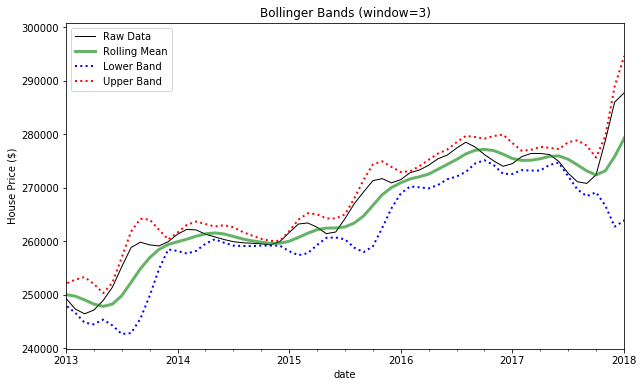

In [136]:
f,ax= calc_bollinger_bands_plot(ts.resample(rule='MS').asfreq(),
                    window=5)
ax.set_xlim('2013','2018')

### Train-Test-Split

In [148]:
# len(ts),len(ts.index)

In [149]:
def get_train_test_split_index(ts, TEST_SIZE=0.2):
    import math
    idx_split = math.floor(len(ts.index)*(1-TEST_SIZE))
    return idx_split

In [150]:
idx_split = get_train_test_split_index(ts,TEST_SIZE=0.1)

ts_train = ts.iloc[:idx_split] 
ts_test = ts.iloc[idx_split:]

display(ts_train.shape)#.style.set_caption('Training Data'))
display(ts_test.shape)#.style.set_caption('Test Data'))

(111,)

(13,)

In [151]:
ts_train.isna().sum(), ts_test.isna().sum()

(0, 0)

### Manual GridSearch for ARIMA (jeff's starter code)

In [152]:
# import warnings
# from statsmodels.tsa.arima_model import ARIMA
# from sklearn.metrics import mean_squared_error

# # evaluate an ARIMA model for a given order (p,d,q)
# def evaluate_arima_model(X, arima_order):
#     # prepare training dataset
#     train_size = int(len(X) * 0.66)
#     train, test = X[0:train_size], X[train_size:]
#     history = [x for x in train]
#     # make predictions
#     predictions = list()
#     for t in range(len(test)):
#         model = ARIMA(history, order=arima_order)
#         model_fit = model.fit(disp=0)
#         yhat = model_fit.forecast()[0]
#         predictions.append(yhat)
#         history.append(test[t])
#     # calculate out of sample error
#     error = mean_squared_error(test, predictions)
#     return error

# # evaluate combinations of p, d and q values for an ARIMA model
# def evaluate_models(dataset, p_values, d_values, q_values):
#     results = [['p','d','q','mse']]
#     dataset = dataset.astype('float32')
#     best_score, best_cfg = float("inf"), None
#     for p in p_values:
#         for d in d_values:
#             for q in q_values:
#                 order = (p,d,q)
#                 try:
#                     mse = evaluate_arima_model(dataset, order)
#                     results.append([p,d,q,mse])
#                     if mse < best_score:
#                         best_score, best_cfg = mse, order
#                     print('ARIMA%s MSE=%.3f' % (order,mse))
#                 except:
#                     continue
#     print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
#     return results

In [153]:
# # evaluate parameters
# p_values = [0, 1, 2, 4]#, 6, 8, 10]
# d_values = range(0, 3)
# q_values = range(0, 3)
# warnings.filterwarnings("ignore")
# results = evaluate_models(ts, p_values, d_values, q_values);
# # results
# # res = fs.list2df(results)

## GridSearch with `pmdarima`

In [154]:
import pmdarima as pm

model = pm.auto_arima(ts_train,
                      start_p=0,start_q=0,start_P=0,start_Q=0, 
                      max_p=5 ,max_q =6 ,max_P= 5,max_Q=5,max_D=3,
                      suppress_warnings=True, stepwise=False, trace=True,
                      m=6,seasonal=True, with_intercept=False,
                      stionarity=False)
model.summary()

Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 0, 0, 6); AIC=1770.202, BIC=1772.894, Fit time=0.006 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 0, 1, 6); AIC=1773.441, BIC=1778.824, Fit time=0.017 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 0, 2, 6); AIC=1777.582, BIC=1785.656, Fit time=0.037 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 0, 3, 6); AIC=1783.256, BIC=1794.022, Fit time=0.247 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 0, 4, 6); AIC=1782.074, BIC=1795.531, Fit time=0.108 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 0, 5, 6); AIC=1785.224, BIC=1801.372, Fit time=0.115 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(1, 0, 0, 6); AIC=1772.203, BIC=1777.586, Fit time=0.013 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(1, 0, 1, 6); AIC=1775.066, BIC=1783.140, Fit time=0.034 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(1, 0, 2, 6); AIC=1778.620, BIC=1789.386, Fit time=0.084 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_o

Fit ARIMA: order=(1, 2, 1) seasonal_order=(2, 0, 1, 6); AIC=1782.332, BIC=1798.480, Fit time=0.081 seconds
Fit ARIMA: order=(1, 2, 1) seasonal_order=(3, 0, 0, 6); AIC=1782.301, BIC=1798.450, Fit time=0.092 seconds
Fit ARIMA: order=(1, 2, 2) seasonal_order=(0, 0, 0, 6); AIC=1775.899, BIC=1786.664, Fit time=0.189 seconds
Fit ARIMA: order=(1, 2, 2) seasonal_order=(0, 0, 1, 6); AIC=1777.909, BIC=1791.366, Fit time=0.278 seconds
Fit ARIMA: order=(1, 2, 2) seasonal_order=(0, 0, 2, 6); AIC=1794.432, BIC=1810.580, Fit time=0.156 seconds
Fit ARIMA: order=(1, 2, 2) seasonal_order=(1, 0, 0, 6); AIC=1777.940, BIC=1791.397, Fit time=0.265 seconds
Fit ARIMA: order=(1, 2, 2) seasonal_order=(1, 0, 1, 6); AIC=1794.428, BIC=1810.576, Fit time=0.233 seconds
Fit ARIMA: order=(1, 2, 2) seasonal_order=(2, 0, 0, 6); AIC=1779.890, BIC=1796.038, Fit time=0.325 seconds
Fit ARIMA: order=(1, 2, 3) seasonal_order=(0, 0, 0, 6); AIC=1793.371, BIC=1806.828, Fit time=0.041 seconds
Fit ARIMA: order=(1, 2, 3) seasonal_o

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  111
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -884.101
Date:                Mon, 30 Dec 2019   AIC                           1770.202
Time:                        17:36:53   BIC                           1772.894
Sample:                             0   HQIC                          1771.294
                                - 111                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      6.494e+05   7.61e+04      8.534      0.000       5e+05    7.99e+05
===================================================================================
Ljung-Box (Q):                      114.77   Jarque-Bera (JB):                 4.53
Prob(Q):                              0.00   Prob(JB):                         0.10
Heteroskedasticity (H):               3.54   Skew:                            -0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [155]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model_sarimax = SARIMAX(ts_train,
                        **model.get_params()).fit()
model_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:              MeanValue   No. Observations:                  111
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -884.101
Date:                Mon, 30 Dec 2019   AIC                           1770.202
Time:                        17:36:53   BIC                           1772.894
Sample:                    01-01-2008   HQIC                          1771.294
                         - 03-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      6.494e+05   7.61e+04      8.534      0.000       5e+05    7.99e+05
===================================================================================
Ljung-Box (Q):                      114.77   Jarque-Bera (JB):                 4.53
Prob(Q):                              0.00   Prob(JB):                         0.10
Heteroskedasticity (H):               3.54   Skew:                            -0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [159]:
def thiels_U(ys_true=None, ys_pred=None,display_equation=True,display_table=True):
    """Calculate's Thiel's U metric for forecasting accuracy.
    Accepts true values and predicted values.
    Returns Thiel's U"""


    from IPython.display import Markdown, Latex, display
    import numpy as np
    display(Markdown(""))
    eqn=" $$U = \\sqrt{\\frac{ \\sum_{t=1 }^{n-1}\\left(\\frac{\\bar{Y}_{t+1} - Y_{t+1}}{Y_t}\\right)^2}{\\sum_{t=1 }^{n-1}\\left(\\frac{Y_{t+1} - Y_{t}}{Y_t}\\right)^2}}$$"

    # url="['Explanation'](https://docs.oracle.com/cd/E57185_01/CBREG/ch06s02s03s04.html)"
    markdown_explanation ="|Thiel's U Value | Interpretation |\n\
    | --- | --- |\n\
    | <1 | Forecasting is better than guessing| \n\
    | 1 | Forecasting is about as good as guessing| \n\
    |>1 | Forecasting is worse than guessing| \n"


    if display_equation and display_table:
        display(Latex(eqn),Markdown(markdown_explanation))#, Latex(eqn))
    elif display_equation:
        display(Latex(eqn))
    elif display_table:
        display(Markdown(markdown_explanation))

    if ys_true is None and ys_pred is None:
        return

    # sum_list = []
    num_list=[]
    denom_list=[]
    for t in range(len(ys_true)-1):
        num_exp = (ys_pred[t+1] - ys_true[t+1])/ys_true[t]
        num_list.append([num_exp**2])
        denom_exp = (ys_true[t+1] - ys_true[t])/ys_true[t]
        denom_list.append([denom_exp**2])
    U = np.sqrt( np.sum(num_list) / np.sum(denom_list))
    return U


In [162]:
def get_model_metrics(true,preds,train,explain_U=False):
    from sklearn.metrics import r2_score, mean_squared_error
    
    results = [['Metric','Value']]
    r2 = r2_score(true,preds)
    results.append(['R^2',r2])
    
    rmse = np.sqrt(mean_squared_error(true,preds))
    results.append(['RMSE',rmse])
    
    if explain_U:
         U_kws = dict(display_equation=True, display_table=True)
    else:
         U_kws = dict(display_equation=False, display_table=False)
    U = thiels_U(true,preds,**U_kws)
    results.append(["Thiel's U",U])
    
    
    fig,axes=plt.subplots(ncols=2,figsize=(12,6))

    ax=axes[0]
    ax.plot(true,label='Test Data')
    ax.plot(preds, label='Model Forecast')
    ax.plot(train,label='Training Data')

    ax.legend()
    
    ax=axes[1]
    ax.scatter(x=true.index,y=true.values,label='Test Data')
    ax.scatter(x=preds.index,y=preds.values,label='Training Data')

    
    res = fs.list2df(results)#,index_col='Metric')
    plt.tight_layout()
    
    return res
    
    
# get_model_metrics(ts_test,preds,ts_train)    
    

,Metric,Value
0,R^2,0.372282
1,RMSE,6495.086901
2,Thiel's U,1.917891


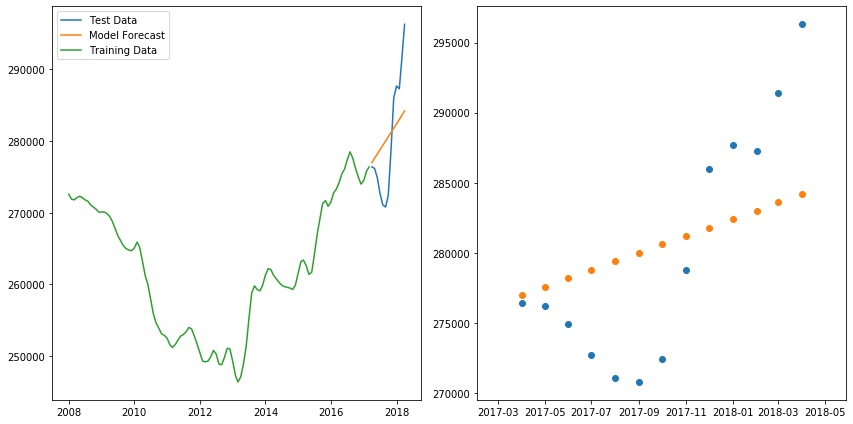

In [165]:
preds = model_sarimax.predict(start=ts_test.index[0],end=ts_test.index[-1])
get_model_metrics(ts_test,preds,ts_train,explain_U=False)    


In [166]:
# from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
# plot_acf(ts);
# plot_pacf(ts);

In [167]:
from sklearn.metrics import r2_score
r2_score(ts_test.values,preds)

0.3722818095853576

In [168]:
thiels_U(ts_test, preds)

<IPython.core.display.Latex object>

|Thiel's U Value | Interpretation |
    | --- | --- |
    | <1 | Forecasting is better than guessing| 
    | 1 | Forecasting is about as good as guessing| 
    |>1 | Forecasting is worse than guessing| 


1.9178907349603882

## BOOKMARK: Meta-Function to Run Everything

In [169]:
def meta_grid_search(ts, TEST_SIZE=0.2,model_kws={},verbose=True,return_kws=False):
    import pmdarima as pm
    from statsmodels.tsa.statespace.sarimax import SARIMAX

    ## Train Test Split
    idx_split = get_train_test_split_index(ts,TEST_SIZE=TEST_SIZE)

    ts_train = ts.iloc[:idx_split].copy()
    ts_test = ts.iloc[idx_split:].copy()
    
    
    ## Combine Default kwargs and model_kws
    model_kwargs = dict(start_p=0,start_q=0,start_P=0,start_Q=0, 
                          max_p=5 ,max_q =6 ,max_P= 5,max_Q=5,max_D=3,
                          suppress_warnings=True, stepwise=False, trace=False,
                          m=6,seasonal=True, with_intercept=True,
                          stionarity=False)
    
    for k,v in model_kws.items():
        model_kwargs[k]=v
    
    if verbose:
        print("pm.auto_arima args:")
        print(model_kwargs)

    model = pm.auto_arima(ts_train,**model_kwargs)
    display(model.summary())
    
    
    model_sarimax = SARIMAX(ts_train,
                            **model.get_params()).fit()
    
    preds = model_sarimax.predict(ts_test.index[0],ts_test.index[-1])
    res = get_model_metrics(ts_test,preds,ts_train)
    display(res)
    
    return model_sarimax
    
#     model_sarimax.summary()


pm.auto_arima args:
{'start_p': 0, 'start_q': 0, 'start_P': 0, 'start_Q': 0, 'max_p': 5, 'max_q': 6, 'max_P': 5, 'max_Q': 5, 'max_D': 3, 'suppress_warnings': True, 'stepwise': False, 'trace': False, 'm': 6, 'seasonal': True, 'with_intercept': True, 'stionarity': False}


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   99
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -786.126
Date:                Mon, 30 Dec 2019   AIC                           1576.253
Time:                        17:38:45   BIC                           1581.402
Sample:                             0   HQIC                          1578.335
                                 - 99                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     12.3711     82.882      0.149      0.881    -150.075     174.818
sigma2      6.411e+05   8.07e+04      7.940      0.000    4.83e+05    7.99e+05
===================================================================================
Ljung-Box (Q):                      138.56   Jarque-Bera (JB):                 3.65
Prob(Q):                              0.00   Prob(JB):                         0.16
Heteroskedasticity (H):               4.27   Skew:                            -0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

,Metric,Value
0,R^2,0.254478
1,RMSE,5480.109488
2,Thiel's U,2.182521


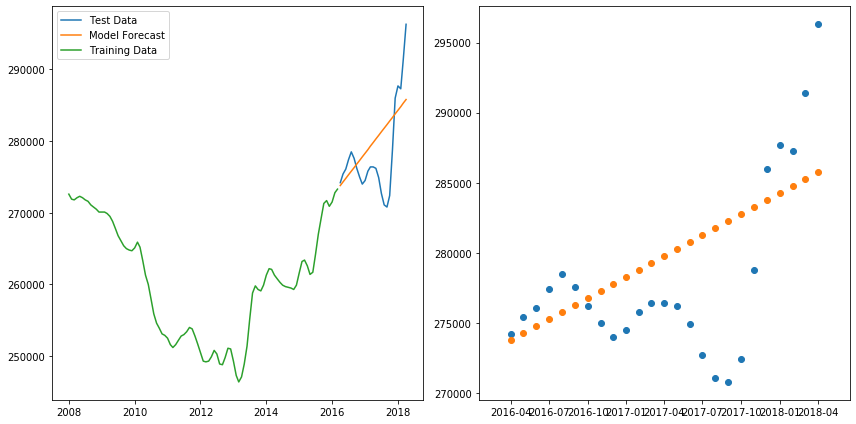

In [170]:
meta_grid_search(ts)

# EARLIER EDA / INVESTIGATION

In [ ]:
zip_list = list(df['RegionID'].unique())
zip_list[0]

In [ ]:
mpl.rcParams['figure.figsize'] = (12,6)
df_small = df.loc[df['RegionID'].isin(zip_list[:1000])]
df_small['datetime'] = df_small.index.to_series()
df_small

In [ ]:
# def plotly_timeseries(df,x='datetime',y='MeanValue',color='RegionID',
#                   line_group='State'):
#     from plotly import express as px
#     import plotly.graph_objects as go

#     pfig = px.line(data_frame=df,x=x,y=y,color=color,
#                   line_group=line_group)

#     pfig.update_layout(title_text='Time Series with Rangeslider',
#                       xaxis_rangeslider_visible=True)

#     # Add range slider
#     pfig.update_layout(
#         xaxis=go.layout.XAxis(
#             rangeselector=dict(
#                 buttons=list([
#                     dict(count=1,
#                          label="1m",
#                          step="month",
#                          stepmode="backward"),
#                     dict(count=6,
#                          label="6m",
#                          step="month",
#                          stepmode="backward"),
#                     dict(count=1,
#                          label="YTD",
#                          step="year",
#                          stepmode="todate"),
#                     dict(count=1,
#                          label="1y",
#                          step="year",
#                          stepmode="backward"),
#                     dict(step="all")
#                 ])
#             ),
#             rangeslider=dict(
#                 visible=True
#             ),
#             type="date"
#         )
#     )
#     return pfig
pfig= plotly_timeseries(df_small)
pfig


In [ ]:
# from plotly import express as px
# import plotly.graph_objects as go

# pfig = px.line(data_frame=df_small,x='datetime',y='MeanValue',color='RegionID',
#               line_group='State')
# # pfig.update_layout({''})

# pfig.update_layout(title_text='Time Series with Rangeslider',
#                   xaxis_rangeslider_visible=True)

# # Add range slider
# pfig.update_layout(
#     xaxis=go.layout.XAxis(
#         rangeselector=dict(
#             buttons=list([
#                 dict(count=1,
#                      label="1m",
#                      step="month",
#                      stepmode="backward"),
#                 dict(count=6,
#                      label="6m",
#                      step="month",
#                      stepmode="backward"),
#                 dict(count=1,
#                      label="YTD",
#                      step="year",
#                      stepmode="todate"),
#                 dict(count=1,
#                      label="1y",
#                      step="year",
#                      stepmode="backward"),
#                 dict(step="all")
#             ])
#         ),
#         rangeslider=dict(
#             visible=True
#         ),
#         type="date"
#     )
# )

### Grabbing only 40 zips

In [ ]:
for i in range(0,40):
    df.groupby('RegionID').get_group(zip_list[i])['MeanValue'].plot(label=zip_list[i])
# plt.legend()

In [ ]:
# i=0
# df.groupby('RegionID').get_group(zip_list[i])['MeanValue'].plot(label=zip_list[i])
# i+=1
# df.groupby('RegionID').get_group(zip_list[i])['MeanValue'].plot(label=zip_list[i])
# plt.legend()

### By State: IL

In [ ]:
df_IL = df.groupby('State').get_group('IL')

il_grps = df_IL.groupby('RegionID').groups
# il_grps.keys()
for grp,rows in il_grps.items():
    plt.plot(df_IL.loc[rows,'MeanValue'].mean())

In [ ]:
df.loc[df['RegionID']==zip_list[0],'MeanValue'].plot()

In [ ]:
fs.jmi.in

In [ ]:
# state_zips = df.groupby(['State','RegionID']).groups

In [ ]:
# zips = df.groupby('RegionID').groups #pd.Grouper(freq='MS')]).groups
# len(zips.keys())

# list_zips = list(zips.keys())
# list_zips[:10]

In [ ]:
# zip_dict={}
# for zipcode in list_zips[:10]:
#     zip_dict[zipcode] = df.loc[zips[zipcode]]

In [ ]:
mpl.rcParams['figure.figsize'] = (12,6)
ax = zip_dict[58196]['MeanValue'].loc['2012':'2016'].resample('MS').plot();

In [ ]:
df.info()

In [ ]:
from pandas_profiling import ProfileReport
ProfileReport(df)

In [ ]:
# def melt_data(df): # BAD PROVIDED FUNCTION
#     melted = pd.melt(df, id_vars=['RegionName', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
#     melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
#     melted = melted.dropna(subset=['value'])
#     return melted.groupby('time').aggregate({'value':'mean'})

# melt_df = melt_data(df)

# Step 2: Data Preprocessing

In [ ]:
def get_datetimes(df):
    return pd.to_datetime(df.columns.values[1:], format='%Y-%m')

In [ ]:
date_cols =  df.columns.values[7:]
date_cols = pd.to_datetime(date_cols,format='%Y-%m')

new_cols_names = list(df.columns)[:7]
new_cols_names.extend(date_cols)
df.columns = new_cols_names
df

In [ ]:
melted = pd.melt(df, id_vars=['RegionName', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
melted
# melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)


In [ ]:
df


# Step 3: EDA and Visualization

In [ ]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

# Step 4: Reshape from Wide to Long Format

In [ ]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

# Step 5: ARIMA Modeling

# Step 6: Interpreting Results